![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)



# Assignment 1: Interpretability

In this assignment, we wil work on the model interpretability. First, we will implement LIME (Local interpretable model-agnostic explanations) and then explore SHAP (SHapley Additive exPlanations). Information about SHAP can be found [here](https://arxiv.org/abs/1705.07874).

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement and Test LIME


The aim of this assignment is to implement LIME using the information from the lecture and the publication. You should rely on the Inception V3 neural network. In addition, the focus would be on analysing the top 1 and top 2 predictions. The focus are images for this assignment. Superpixels are allowed to be used for making the task easier.
Note that you should not use an available LIME python-based library.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

<img src="https://upload.wikimedia.org/wikipedia/commons/2/2b/Schloss-Erlangen02.JPG" 
width="300"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/0/0c/Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG" width="300"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Alte-universitaets-bibliothek_universitaet-erlangen.jpg" width="300"/>

In [1]:
import torch
import numpy as np
import copy
from skimage.segmentation import slic, quickshift
from sklearn.linear_model import LinearRegression
from sklearn.metrics import pairwise_distances
from torchvision import transforms
from PIL import Image
import skimage.io
import matplotlib.pyplot as plt

In [2]:
def view_result(image, coeff, num_superpixels, superpixels):
    num_top_features = 5
    top_features = np.argsort(coeff)[-num_top_features:]

    mask = np.zeros(num_superpixels)
    mask[top_features] = True  # Activate top superpixels
    # skimage.io.imshow(perturb_image_v2(image / 2 + 0.5, mask, superpixels))
    skimage.io.imshow(perturb_image_v2(np.array(image) / 2 + 0.5, mask, superpixels))
    # perturbed_squeezed_tensor * 255).permute(1, 2, 0).byte().numpy(),
    skimage.io.show()

In [3]:
def perturb_image_v2(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:, :, np.newaxis]

    return perturbed_image

In [4]:
def preprocess_and_predict_v2(image, model, perturbation_times):
    preprocess = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
    ])

    toTensor = transforms.Compose([
        transforms.ToTensor(),
    ])

    superpixels_or_segments = quickshift(image, kernel_size=3, max_dist=200, ratio=0.4)

    num_superpixels = np.unique(superpixels_or_segments).shape[0]

    # Generate perturbations
    perturbations = np.random.binomial(1, 0.5, size=(perturbation_times, num_superpixels))

    perturbed_images = []
    for pert in perturbations:
        perturbed_image = perturb_image_v2(image, pert, superpixels_or_segments)
        perturbed_image_tensor = toTensor(perturbed_image)
        perturbed_images.append(perturbed_image_tensor.unsqueeze(0))

    perturbed_images_tensor = torch.cat(perturbed_images)

    input_preprocess_image = preprocess(image)
    input_tensor = input_preprocess_image.unsqueeze(0)

    batch = torch.from_numpy(np.concatenate((input_tensor, perturbed_images_tensor), axis=0))

    with torch.no_grad():
        predictions = model(batch.float()).detach().numpy() # --> .detach().numpy() this converts returned tensor to numpy

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    # probabilities = torch.nn.functional.softmax(predictions[0], dim=0)
    # print(probabilities)

    return predictions, perturbations, num_superpixels, superpixels_or_segments, perturbed_images


In [5]:
def lime_explanation(image, model, perturbation_times=10):
    (predictions, perturbations, num_superpixels, superpixels_or_segments, perturbed_images) = preprocess_and_predict_v2(
        image, model, perturbation_times)

    original_image = np.ones(num_superpixels)[np.newaxis, :]

    distances = pairwise_distances(perturbations, original_image, metric='euclidean').ravel()

    weights = np.exp(-distances / np.std(distances))

    top_pred_classes = predictions[0].argsort()[-5:][::1] # Save ids of top 5 classes
    class_to_explain = top_pred_classes[0]

    interpretable_model = LinearRegression()
    interpretable_model.fit(X=perturbations, y=predictions[1:, class_to_explain], sample_weight=weights)

    explanation = interpretable_model.coef_

    return explanation, perturbed_images

Using cache found in C:\Users\eg87oqic/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Python\venv310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Python\venv310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


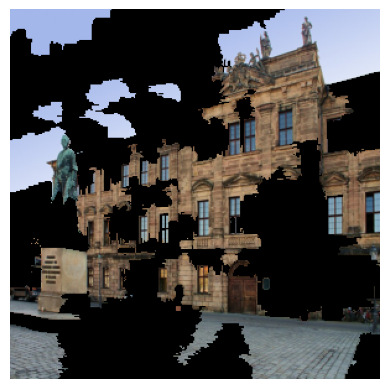

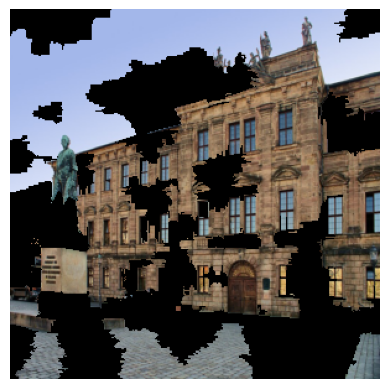

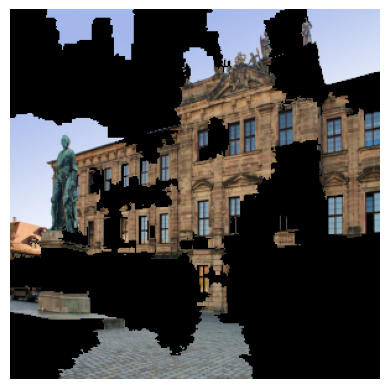

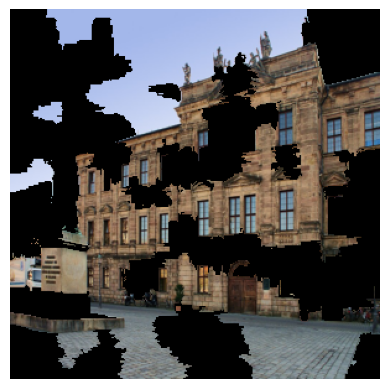

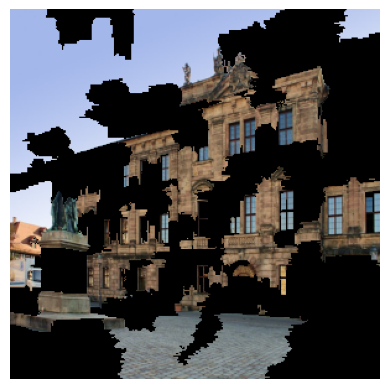

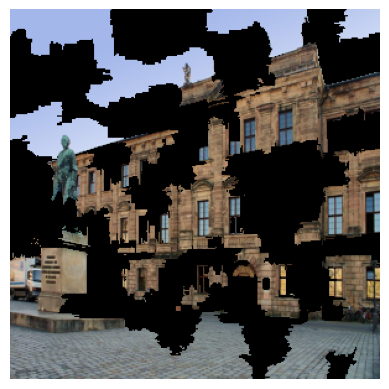

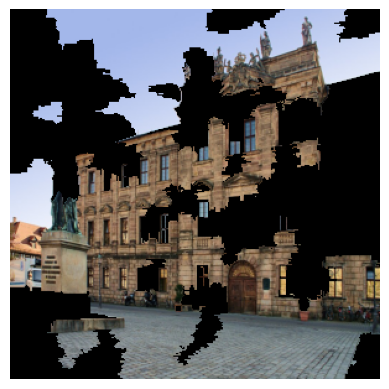

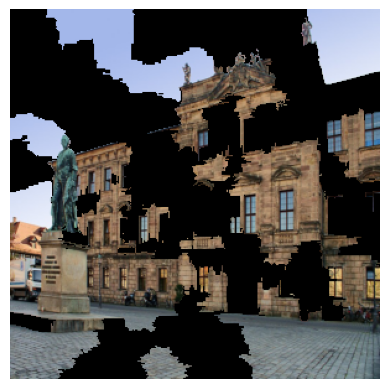

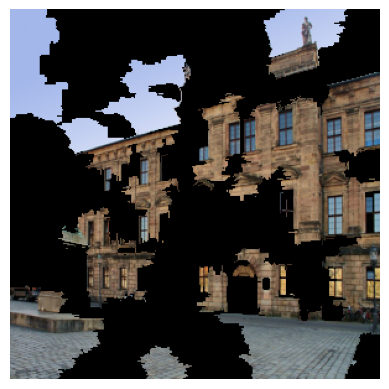

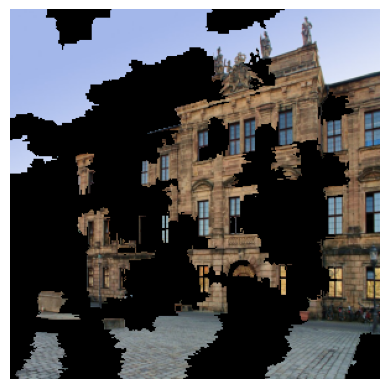

Explanation: [-0.0221569  -0.04745128  0.02949934  0.00048672 -0.03513727 -0.10952068
 -0.08277635  0.0370443   0.01180458 -0.04605511 -0.06717175 -0.10938539
  0.03269292 -0.03571751 -0.08653721  0.03647348 -0.0338137   0.02366104
 -0.03665131 -0.07341937  0.00643793 -0.02641188  0.05221316  0.03289905
 -0.02659605  0.07875753 -0.05118648  0.01411558 -0.08049561  0.00957553
 -0.03258507  0.0693251   0.02868843 -0.03665412 -0.00877959 -0.07944226
  0.0573479  -0.00679594 -0.04552413  0.07842024 -0.04070551 -0.12361853
 -0.06406615 -0.04395016 -0.02219877  0.02184393  0.01068215  0.01975346
 -0.01231632 -0.01839735 -0.0247381   0.01019049 -0.0047212   0.03384954
 -0.02704658 -0.05500882  0.03705746 -0.09158693  0.02262873 -0.01664767
 -0.09445165 -0.00603114  0.02603665 -0.00416661  0.04581992 -0.00734148
 -0.04864641 -0.04010884  0.07579458 -0.03371682  0.02241298  0.07842024
 -0.00162959 -0.00304219 -0.08767427 -0.05346331 -0.05952862 -0.12197383
 -0.10007181 -0.02008356 -0.08661069  

In [6]:
# Load image data
img1 = Image.open('.\\images\\1024px-Schloss-Erlangen02.jpg')
img2 = Image.open('.\\images\\1024px-Alte-universitaets-bibliothek_universitaet-erlangen.jpg')
img3 = Image.open('.\\images\\1024px-Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.jpg')

# Load Inception v3 neural network model
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

model.aux_logits = False

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299,299)),
])

# Change image here
image = resize(np.array(img1))

perturbation_time = 10
explanation, perturbed_images = lime_explanation(image, model, perturbation_times=perturbation_time)

plt.figure()
for i in range(perturbation_time):
    perturbed_squeezed_tensor = torch.squeeze(perturbed_images[i], dim=0)
    plt.imshow((perturbed_squeezed_tensor).permute(1, 2, 0).byte().numpy())
    plt.axis('off')  # Turn off axis labels
    plt.show()

print("Explanation:", explanation)

In [8]:
explanation.shape

(114,)

## 2. Test SHAP

For the same images, you should now use the SHAP algorithm to provide visual explanations. In this case, you do not need to implement the algorithm. Instead, you could use an existing Python library such as [SHAP](https://shap.readthedocs.io/en/latest/image_examples.html). ResNet 50 is a good reference for running the tests. Inception V3 can also be used. For this task, [TensorFlow](https://www.tensorflow.org) can be used as well.

The test image are the following Wikipedia entries:
[Image 1](https://commons.wikimedia.org/wiki/File:Schloss-Erlangen02.JPG)
[Image 2](https://commons.wikimedia.org/wiki/File:Erlangen_Blick_vom_Burgberg_auf_die_Innenstadt_2009_001.JPG)
[Image 3](https://commons.wikimedia.org/wiki/File:Alte-universitaets-bibliothek_universitaet-erlangen.jpg)

![](https://shap.readthedocs.io/en/latest/_images/example_notebooks_image_examples_image_classification_Explain_ResNet50_using_the_Partition_explainer_10_0.png)

In [ ]:
# !pip install -U scikit-image

In [ ]:
# !pip install -U scikit-learn

In [ ]:
### Source: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html 
#
# 
# import matplotlib.pyplot as plt
# import numpy as np

# from skimage.data import astronaut
# from skimage.color import rgb2gray
# from skimage.filters import sobel
# from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
# from skimage.segmentation import mark_boundaries
# from skimage.util import img_as_float

img = img_as_float(astronaut()[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1, start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()